<a href="https://colab.research.google.com/github/nishinorinsei/nishinorinsei.github.io/blob/main/ensyu_3_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 音声信号処理の基本　(低域通過フィルタリング)

ここではPythonを使って音声信号処理の基本について勉強しましょう．
低域通過フィルタの実装，および音声信号のフィルタリングを通じて，音声信号処理の流れを体験します．

---

必要なモジュールをインストール & インポートします．

In [1]:
!pip install japanize-matplotlib -U

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.1/4.1 MB 23.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for japanize-matplotlib: filename=japanize_matplotlib-1.1.3-py3-none-any.whl size=4120257 sha256=3bd33c70694102998336a49fcc4d9b414779c3680fb31b4570dee7a7e1bef145
  Stored in directory: /root/.cache/pip/wheels/c1/f7/9b/418f19a7b9340fc16e071e89efc379aca68d40238b258df53d
Successfully built japanize-matplotlib


In [2]:
import numpy as np
import scipy.signal as sg       # 信号処理モジュール
import soundfile as sf          # wavファイルを扱う際のモジュール
import IPython.display as disp  # iPython上でファイルを扱うためのモジュール
import urllib.request           # ファイルを読み込むためのモジュール
import matplotlib.pyplot as plt # 図を表示させるためのモジュール
import japanize_matplotlib      # 日本語を扱うためのモジュール

## 0. 音声の読み込みと確認
音声ファイルの読み込みを行います．音声ファイルは，モノラルマイクで収録されたモノラル音声です．音声を読み込み，x とします．

また，音声信号の各サンプルに対応する時刻[s]をもった配列として t を作成します．

In [3]:
# wavファイルをGoogle colabのワークスペースにもってくる
urllib.request.urlretrieve('https://raw.githubusercontent.com/YosukeSugiura/SougouEnshu-A/master/sound_mono.wav', 'sound_mono.wav')
# wavファイルの読み込み
x, fs = sf.read('sound_mono.wav')  # 戻り値：データ, サンプリング周波数
x.shape
t = np.arange(len(x))/fs # 各サンプルの時刻(波形の図示で使う)

音声波形を図で確認します．

Text(0.5, -0.4, '音声波形')

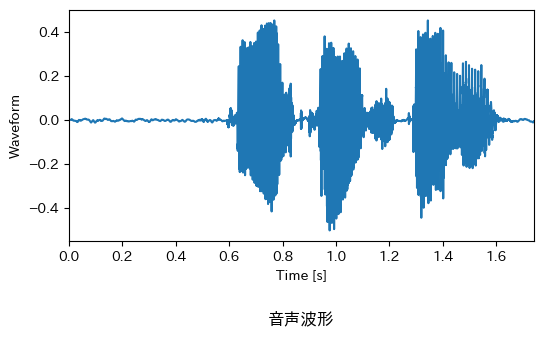

In [4]:
fig1 = plt.figure(num=1, figsize=(6,3))

# 複数のグラフを作成
ax1 = fig1.add_subplot(111) # グラフを作成

# 各グラフをプロット
ax1.plot(t, x)

# 軸名・範囲の設定
ax1.set_xlim([t[0], t[-1]])
ax1.set_ylabel("Waveform")
ax1.set_xlabel("Time [s]")
plt.title("音声波形", y=-0.4)

音声を聞くこともできます(イヤホン推奨)．

In [5]:
print('音声')
disp.Audio(x.T, rate = fs)

音声


## 1. 音声のSTFT

音声をフレームごとに分割して，短時間フーリエ変換(STFT)を行います．
関数`sg.stft`を用いれば，フレーム分割・窓関数・STFTもすべて一括で行ってくれます．
STFT後の周波数スペクトログラムは X に保存します．

ここではフレーム長を1024サンプル，シフト長を512サンプルに設定しています．
このとき，隣り合うフレームとの重複サンプル数(=オーバーラップ幅)は 1024-512=512サンプルになります．

In [6]:
# セグメント長，シフト長の指定
n_seg = 1024
n_shift = 512

# 各チャンネルごとに短時間フーリエ変換において
f, t, X = sg.stft(x, fs=fs, nperseg=n_seg, noverlap=n_seg-n_shift) # 戻り値：周波数，時刻，周波数スペクトル

スペクトログラム X においては，第１次元が周波数ビンに対応し，第２次元がフレーム番号に対応します．周波数ビンとは，周波数に対応する番号を指します．周波数ビンと周波数の変換式，および対応例は以下の通りです．

```
周波数ビン→周波数の変換式：  
    (周波数) = fs *  (周波数ビン) / n_seg

周波数 → 周波数ビンの変換式：
    (周波数ビン) = round( n_seg *  (周波数) / fs )

周波数ビンと周波数の対応：
    ・周波数ビンの最小値(ここでは 0) → 周波数 0Hz  
    ・周波数ビンの最大値(ここでは 513) → 周波数 fs/2 Hz
```

得られたスペクトルのサイズ(=X.shape) は (513, 56) となります．これは周波数ビン数が513，フレーム数が56を意味します．


In [7]:
X.shape

(513, 56)

ちなみにサンプリング周波数 fs は16000Hzです．

In [8]:
fs

16000

音声のスペクトログラムを確認します．
ここでは音声の特徴が見やすいように，0Hz～2kHzまでを表示しています．

Text(0.5, -0.4, '音声のスペクトログラム')

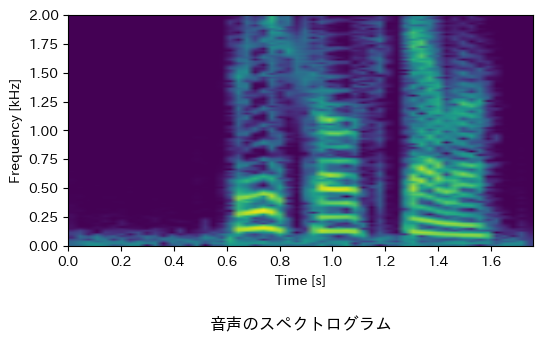

In [9]:
# パワースペクトログラムの計算
S_x = 10*np.log10(np.abs(X)**2+10**(-8))  # dB単位

# 図の用意
fig2 = plt.figure(num=2, figsize=(6,3))

# 複数のグラフを作成
ax1 = fig2.add_subplot(111) # グラフを作成

# 各グラフをプロット
extent = [t.min(), t.max(), f.min()/1000, f.max()/1000]
ax1.imshow(S_x, aspect='auto', origin='lower', interpolation='bilinear', extent=extent)

# 軸名・範囲の設定
ax1.set_ylim([0,2]) # 0~2kHzまでを表示
ax1.set_ylabel("Frequency [kHz]")
ax1.set_xlabel("Time [s]")
plt.title("音声のスペクトログラム", y=-0.4)

## 2. 周波数領域フィルタリング

スペクトログラムに周波数マスクをかけてフィルタリングを行いましょう．この演習では，以下の条件を満たす低域通過フィルタを実現しましょう．
```
低域通過フィルタの条件：
- カットオフ周波数 : 1000Hz (1000Hzより低い周波数成分のみ抽出する)
```
したがって，作成するマスクは，1000Hz以下の周波数成分に対応する値を1に設定し，1000Hzより高い周波数成分に対応する値を 0 にします．

In [10]:
# マスクの作成

#↓↓ ここに低域通過フィルタを実現するマスクを作成しよう！
#     このサンプルコードでは，マスクのすべての値を1(=すべての周波数成分をそのまま通過させる)にしています．
#     自身で書き換えて，低域通過フィルタを実装しましょう．
#--------------------------------------
cutoff_f = 1000   # カットオフ周波数を1000Hzとする

# 周波数マスク
H = np.zeros(X.shape)  # すべての周波数成分で1の値をもつ周波数マスク
H[f <= cutoff_f, :] = 1
#--------------------------------------
#↑↑ここまで

# フィルタリング
Y = H * X

処理後の音声のスペクトログラムを表示し，低域のみが抽出されることを確認しましょう．

(このサンプルコードは，入力音声をそのまま出力するフィルタリングを行っています．したがってオリジナルのままでは，入力音声と同じスペクトログラムが得られます．)

Text(0.5, -0.4, '処理音声のスペクトログラム')

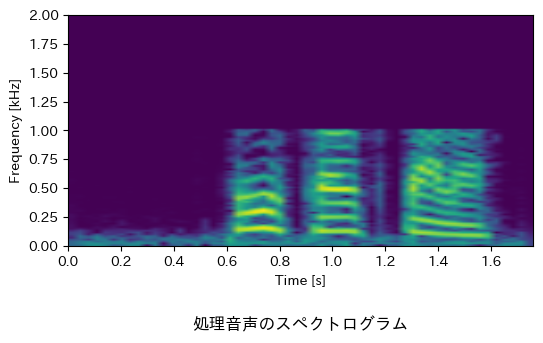

In [11]:
# パワースペクトログラムの計算
S_y = 10*np.log10(np.abs(Y)**2+10**(-8))  # dB単位

# 図の用意
fig3 = plt.figure(num=2, figsize=(6,3))

# 複数のグラフを作成
ax1 = fig3.add_subplot(111) # グラフを作成

# 各グラフをプロット
extent = [t.min(), t.max(), f.min()/1000, f.max()/1000]
ax1.imshow(S_y, aspect='auto', origin='lower', interpolation='bilinear', extent=extent)

# 軸名・範囲の設定
ax1.set_ylim([0,2]) # 0~2kHzまでを表示
ax1.set_ylabel("Frequency [kHz]")
ax1.set_xlabel("Time [s]")
plt.title("処理音声のスペクトログラム", y=-0.4)

## 3. ISTFTによる音声波形の復元

処理音声に対して逆短時間フーリエ変換(Inverse Short Fourier Transform:ISTFT)を行い，音声波形を復元します．関数`sg.istft`を用いれば，オーバーラップアドも同時に行ってくれます．



In [12]:
# 短時間フーリエ変換 + オーバーラップアド
t, y = sg.istft(Y, fs=fs, nperseg=n_seg, noverlap=n_seg-n_shift) # 戻り値：時刻，時間波形

音声波形を確認します．

Text(0.5, -0.4, '処理音声の波形')

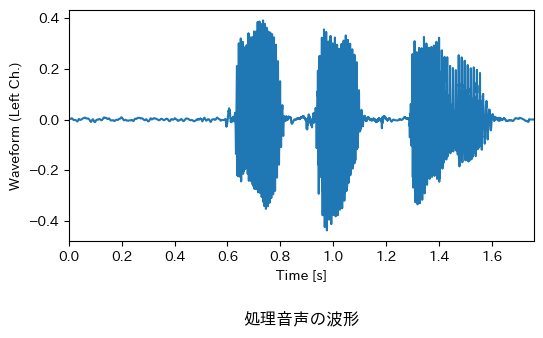

In [13]:
fig4 = plt.figure(num=1, figsize=(6,3))

# 複数のグラフを作成
ax1 = fig4.add_subplot(111) # グラフを作成

# 各グラフをプロット
ax1.plot(t, y)

# 軸名・範囲の設定
ax1.set_xlim([t[0], t[-1]])
ax1.set_ylabel("Waveform (Left Ch.)")
ax1.set_xlabel("Time [s]")
plt.title("処理音声の波形", y=-0.4)

処理音声を聞いて正しくフィルタリングされていることを確認します．

In [14]:
print('処理音声')
disp.Audio(y, rate = fs)

処理音声


以下のコードで処理音声のwavファイルをダウンロードできます．

In [ ]:
sf.write('processed_sound2-1.wav', y, fs)

from google.colab import files
files.download('processed_sound2-1.wav')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>